In [11]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Scikit-learn
from sklearn.metrics import r2_score

In [12]:
class Net(nn.Module):
    # neural network model
    def __init__(self, input_dim, output_dim, num_units, dropout, init_log_noise):
        super().__init__()
        # data information
        self.input_dim = input_dim
        self.output_dim = output_dim
        # hyperparameters
        self.num_units = num_units
        self.dropout = dropout
        self.init_log_noise = init_log_noise
        
        # define network layers
        self.l1 = nn.Linear(self.input_dim, self.num_units)
        self.l2 = nn.Linear(self.num_units, self.output_dim)
        
        # noise
        self.log_noise = nn.Parameter(torch.tensor([self.init_log_noise], dtype = torch.float))
        
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = F.dropout(x, p = self.dropout)
        
        x = self.l2(x)
        
        return x

In [13]:
# loss function
# negative log likelihood
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)  
    return -(log_coeff + exponent).sum()

In [14]:
# função para geração dos dados
np.random.seed(2)
def define_dataset(rebuild_data = False, size = 50):
    if rebuild_data == True:
        X = np.random.uniform(-4, 4, size=size).reshape(-1, 1)
        noise = np.random.normal(0, 3, size=size).reshape(-1, 1)
        y = X ** 3 + noise
        data = np.hstack((X,y))
        np.save('dataset.npy', data)    
    dataset = np.load('dataset.npy')
    return dataset

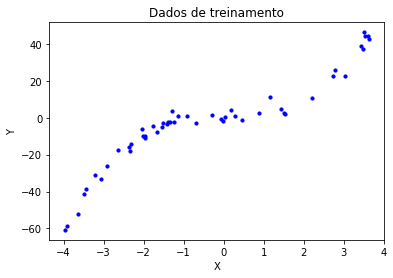

In [15]:
# dados de treinamento
dataset = define_dataset(rebuild_data = False, size = 50)
X_train = dataset[:,0]
y_train = dataset[:,1]

# curva real
X_true = np.linspace(-4, 4, 50).reshape(-1, 1)
y_true = X_true ** 3

# conversão para tensores
X_train_tensor = torch.as_tensor(X_train, dtype = torch.float32).view(-1,1)
y_train_tensor = torch.as_tensor(y_train, dtype = torch.float32).view(-1,1)

# plot dos dados 
plt.scatter(X_train, y_train, marker='o', label='Dados de treinamento', c='b', s=10)
#plt.plot(X_true, y_true, label='Curva Y = X^3')
plt.title('Dados de treinamento')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1023.66it/s]


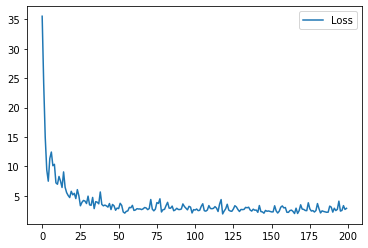

In [16]:
# training neural network
learn_rate = 0.08
batch_size = len(X_train)
num_batches = 1

# sigma
noise = torch.Tensor([[3]])

net = Net(input_dim = 1, output_dim = 1, num_units = 100, dropout = 0.5, init_log_noise = 0)
optimizer = optim.Adam(net.parameters(), lr = learn_rate)
loss_function = log_gaussian_loss

num_epochs = 200
loss_log = []
for i in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = net(X_train_tensor)
    loss = loss_function(output, y_train_tensor, noise, 1)/len(X_train)
    loss_log.append(loss.item())
    loss.backward()
    optimizer.step()

plt.plot(range(num_epochs), loss_log, label = 'Loss')
plt.legend()
plt.show()    

In [17]:
# Dados de teste
X_test = np.linspace(-5,5)
y_test = X_test ** 3
X_test_tensor = torch.as_tensor(X_test, dtype = torch.float32).view(-1,1)
y_test_tensor = torch.as_tensor(y_test, dtype = torch.float32).view(-1,1)

In [18]:
# Monte Carlo dropout
with torch.no_grad():
    samples = []
    noise = []
    # number of samples
    T = 1000 
    for i in tqdm(range(T)):
        pred = net.forward(X_test_tensor)
        pred = pred.numpy()
        samples.append(pred)
    # results
    samples = np.array(samples)
    mean = np.mean(samples, axis = 0).reshape(-1)
    var = np.var(samples, axis = 0).reshape(-1)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7646.11it/s]


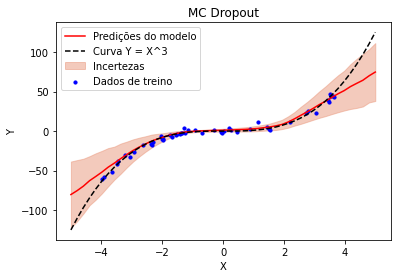

In [19]:
plt.plot(X_test, mean, 'r-', label='Predições do modelo')
plt.fill_between(X_test, 
                 mean + 3*(var**0.5), 
                 mean - 3*(var**0.5), 
                 alpha=0.5, color ='darksalmon', label='Incertezas')
plt.plot(X_test, y_test, 'k--', label='Curva Y = X^3')
plt.scatter(X_train, y_train, marker='o', c='b', label='Dados de treino',  s=10)
plt.title('MC Dropout')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('mcdropout.png')
plt.show()

Coefficient of Determination $R^{2}$

In [20]:
r2 = r2_score(y_test, mean)
r2

0.9101945317454043